In [1]:
# Import packages
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import PIL
import pathlib
import os
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
import requests
!pip install pyunpack patool
import pyunpack
import matplotlib.pyplot as plt
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import sys
from tensorflow.keras.preprocessing.image import ImageDataGenerator

!pip install rarfile segmentation-models git+https://github.com/davej23/image-segmentation-keras.git rioxarray
# from rarfile import RarFile
# import segmentation_models as sm
# from keras_segmentation.models import segnet
# from keras.applications import vgg16
from sklearn.metrics import *
!pip install rioxarray
import rioxarray as rxr

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

from keras.utils import register_keras_serializable
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import os


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 1.4 MB/s eta 0:00:00
  Cloning https://github.com/davej23/image-segmentation-keras.git to /tmp/pip-req-build-4izcngmk
  Running command git clone --filter=blob:none --quiet https://github.com/davej23/image-segmentation-keras.git /tmp/pip-req-build-4izcngmk
  Resolved https://github.com/davej23/image-segmentation-keras.git to commit e01b0a8d5859854cd9d259a618829889166439f5
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.1/301.1 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 41.0 MB/s eta 0:00:00
  Created wheel for keras-segmentation: filename=keras_segmentation-0.3.0-py3-none

In [7]:
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.14.0


In [15]:

# Custom IoU metric

@register_keras_serializable()
def mean_iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * K.round(y_pred)))
    union = K.sum(K.abs(y_true) + K.abs(K.round(y_pred)) - y_true * K.round(y_pred))
    iou = intersection / (union + K.epsilon())
    return iou

(1, 512, 512, 3)


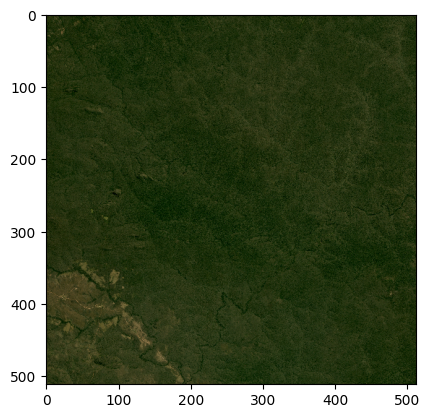

In [20]:

bolivia_path = "/content/drive/MyDrive/Deep Learning final project/Limited scope of research for presentation/2years_visual_full/planet_medres_visual_2017-06_2017-11_mosaic_672-928.tif"
a = (np.array(rxr.open_rasterio(bolivia_path)))
a = (a-np.min(a)) / (np.max(a)-np.min(a))

output_size = (512, 512)

# Reshape and resize using cv2.resize
reshaped_image = cv2.resize(a.transpose(1, 2, 0), output_size)

# Select the first three channels
reshaped_image = reshaped_image[:, :, :3]

# Add an additional dimension for batch size
reshaped_image = reshaped_image[np.newaxis, :, :, :]

# Verify the shape of the reshaped image
print(reshaped_image.shape)

squeezed_img = np.squeeze(reshaped_image)
plt.imshow(squeezed_img)


In [9]:
loaded_model = load_model("/content/drive/MyDrive/Deep Learning final project/final_models/model_unet.keras")

In [10]:
'''
  Returns an image plot of mask prediction
'''

def reconstruct_image(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])
  # Standardise between 0-1
  reconstruction = reconstruction/np.max(reconstruction)

  # Round to 0-1, binary pixel-by-pixel classification
  if rounded:
    reconstruction = np.round(reconstruction)

  # Plot reconstructed mask (prediction)
  plt.imshow(reconstruction)

In [11]:
'''
  Returns array of mask prediction, given model and image
'''
def reconstruct_array(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])

  if rounded:
    reconstruction = np.round(reconstruction)

  return reconstruction # Returns array

In [18]:
model_attention_unet_3band = reconstruct_array(loaded_model, reshaped_image, rounded=False)
model_attention_unet_3band.shape
# model_attention_unet_3band = model_attention_unet_3band * 255
plt.imshow(model_attention_unet_3band, cmap = 'gray')

1/1 [==============================] - 16s 16s/step


In [23]:
np.sum(model_attention_unet_3band)

153590.44

In [26]:

def plotting_ground_truth_and_predictions(file_path, model = loaded_model, super_title = ""):

  a = (np.array(rxr.open_rasterio(file_path)))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))

  output_size = (512, 512)

  reshaped_image = cv2.resize(a.transpose(1, 2, 0), output_size)
  reshaped_image = reshaped_image[:, :, :3]
  reshaped_image = reshaped_image[np.newaxis, :, :, :]
  squeezed_img = np.squeeze(reshaped_image)

  predicted_image = reconstruct_array(model, reshaped_image, rounded=False)


  # model_attention_unet_3band = model_attention_unet_3band * 255
  # plt.imshow(model_attention_unet_3band, cmap = 'gray')

  # Create a figure with two subplots in one row and two columns
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))

  # Plot the first image on the first subplot
  axes[0].imshow(squeezed_img)
  axes[0].set_title('Ground Truth')
  axes[0].axis('off')

  # Plot the second image on the second subplot
  axes[1].imshow(predicted_image, cmap = 'gray')
  axes[1].set_title('Predicted Mask')
  axes[1].axis('off')

  # Adjust layout for better spacing
  plt.tight_layout()
  plt.suptitle(super_title)

  # Show the plot
  plt.show()




1/1 [==============================] - 8s 8s/step


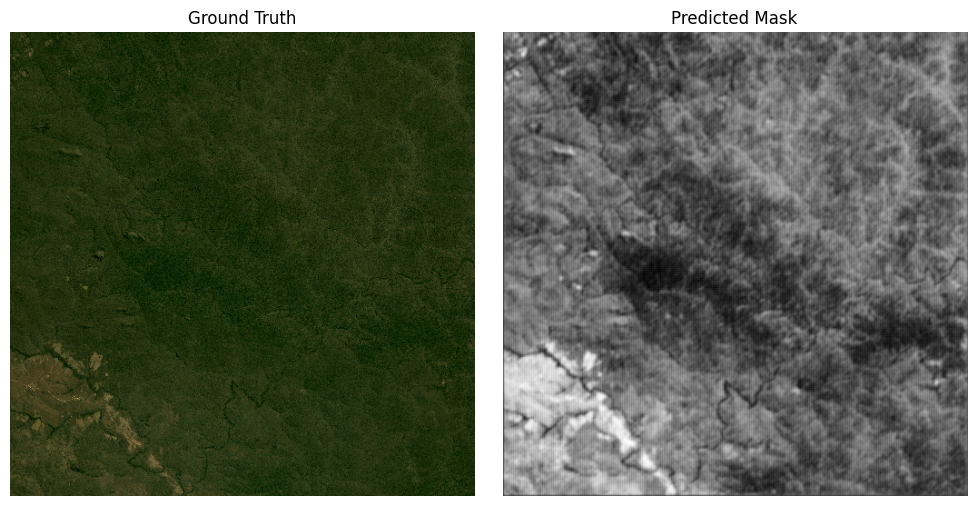

1/1 [==============================] - 7s 7s/step


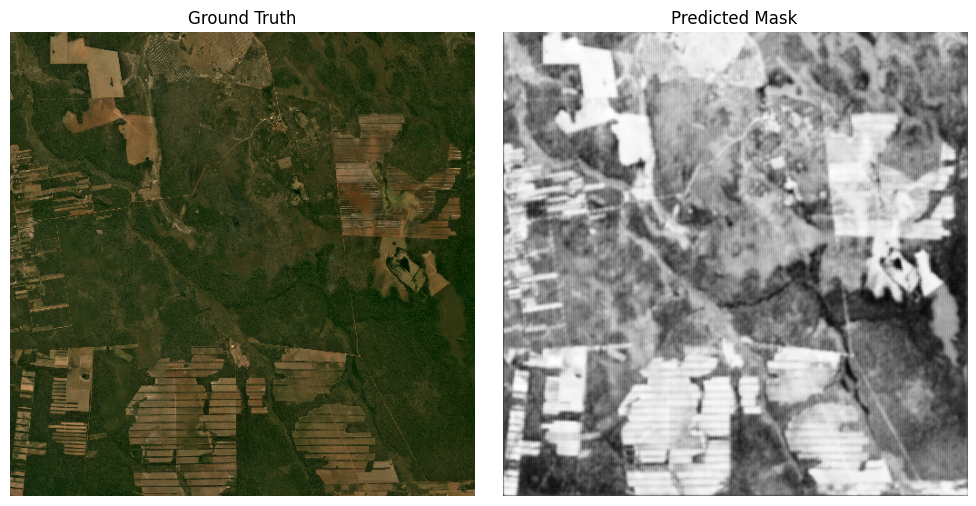

1/1 [==============================] - 10s 10s/step


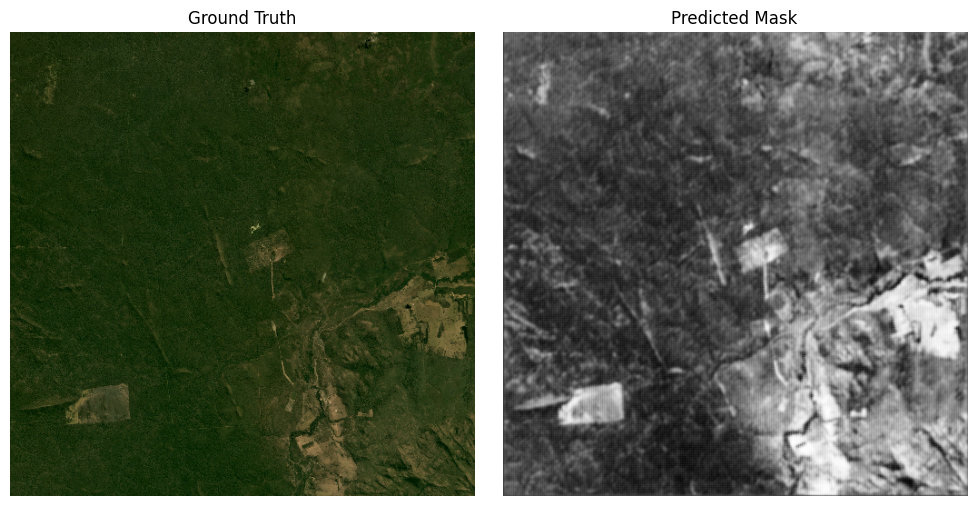

1/1 [==============================] - 9s 9s/step


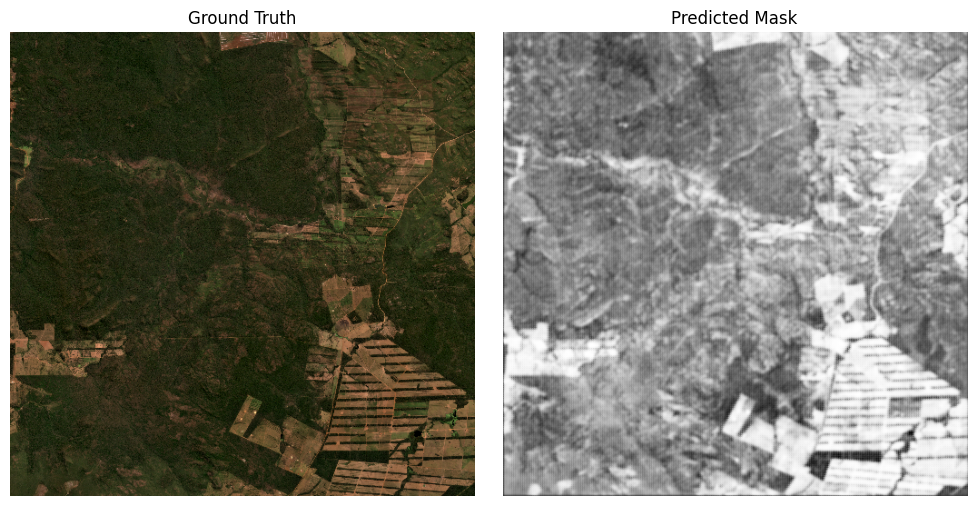

In [28]:
bolivia_path = "/content/drive/MyDrive/Deep Learning final project/Limited scope of research for presentation/2years_visual_full/planet_medres_visual_2017-06_2017-11_mosaic_672-928.tif"
plotting_ground_truth_and_predictions(bolivia_path, model = loaded_model)
bolivia_path = "/content/drive/MyDrive/Deep Learning final project/Limited scope of research for presentation/2years_visual_full/planet_medres_visual_2017-06_2017-11_mosaic_674-931.tif"
plotting_ground_truth_and_predictions(bolivia_path, model = loaded_model)
bolivia_path = "/content/drive/MyDrive/Deep Learning final project/Limited scope of research for presentation/2years_visual_full/planet_medres_visual_2017-06_2017-11_mosaic_676-933.tif"
plotting_ground_truth_and_predictions(bolivia_path, model = loaded_model)
bolivia_path = "/content/drive/MyDrive/Deep Learning final project/Limited scope of research for presentation/2years_visual_full/planet_medres_visual_2023-08_mosaic_676-932.tif"
plotting_ground_truth_and_predictions(bolivia_path, model = loaded_model)


In [34]:

file_path = "/content/drive/MyDrive/Deep Learning final project/Limited scope of research for presentation/2years_visual_full"

empty_dict = {}

for image in tqdm(os.listdir(file_path)):

  a = (np.array(rxr.open_rasterio(file_path + "/" + image)))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))

  output_size = (512, 512)

  reshaped_image = cv2.resize(a.transpose(1, 2, 0), output_size)
  reshaped_image = reshaped_image[:, :, :3]
  reshaped_image = reshaped_image[np.newaxis, :, :, :]

  predicted_image = reconstruct_array(loaded_model, reshaped_image, rounded=False)

  empty_dict[image] = np.sum(predicted_image)


  0%|          | 0/72 [00:00<?, ?it/s]

1/1 [==============================] - 7s 7s/step


In [93]:
results = pd.DataFrame.from_dict(empty_dict, orient='index')
results = results.reset_index()
results = results.set_axis(['name', "np_sum"], axis=1)
results["year"] = [x.split('_')[3][:4] for x in results["name"]]
results["region"] = [x.split('_')[-1][:7] for x in results["name"]]
results.head()

name         np_sum  year  \
0  planet_medres_visual_2023-08_mosaic_672-933.tif  206080.703125  2023   
1  planet_medres_visual_2023-08_mosaic_673-933.tif  202715.843750  2023   
2  planet_medres_visual_2023-08_mosaic_674-933.tif  199628.796875  2023   
3  planet_medres_visual_2023-08_mosaic_675-933.tif  177291.500000  2023   
4  planet_medres_visual_2023-08_mosaic_676-933.tif  191417.328125  2023   

    region  
0  672-933  
1  673-933  
2  674-933  
3  675-933  
4  676-933

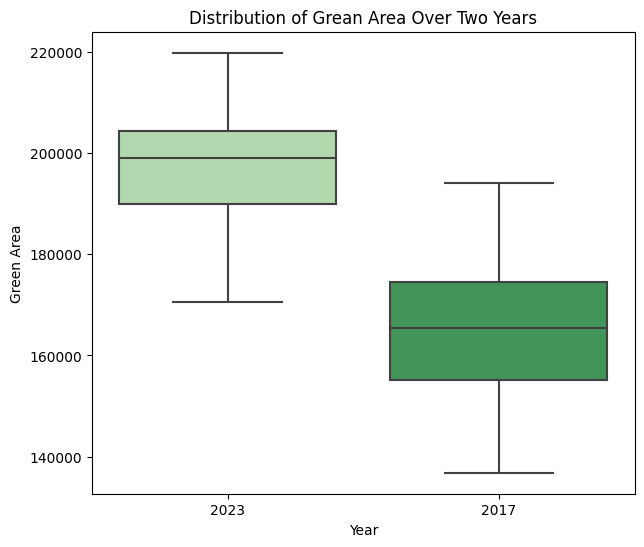

In [91]:
# Create boxplots
plt.figure(figsize=(7, 6))
sns.boxplot(x=results.year, y=results.np_sum, palette='Greens')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Green Area')
plt.title('Distribution of Grean Area Over Two Years')

# Show the plot
plt.show()
